# Object-centric Auto-encoders and Dummy Anomalies for Abnormal Event Detection in Video

I trained the 3 autoencoders overnight for 200 epochs on my macbook using accelerated pytorch training (MPS: Metal Performance Shaders)

In [1]:
import torch
import os
import cv2
import numpy as np
import random
import json
from tqdm import tqdm
from glob import glob
import torchvision

ROOT_DIR = '../AvenueDatasetCopy/Avenue_Corrupted/Dataset'
TESTING_DATA_DIR = '../AvenueDatasetCopy/Avenue_Corrupted/Dataset/testing_videos'

# Metal perforamnce shader backend framework for mac (apple silicon M3 chip)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


Preprocess testing data. Unflip the vertically flipped frames

In [7]:
# Unflip test video frames in place, i.e. replace the old .jpg file

def fix_flipped_frames_inplace(root_dir):
    total_fixed_count = 0

    #  Get all video folders
    video_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])

    for folder in video_folders:
        folder_path = os.path.join(root_dir, folder)
        frame_paths = sorted(glob(os.path.join(folder_path, "*.jpg")))

        # Sample 20 random frames to estimate the correct background.
        sample_paths = random.sample(frame_paths, min(len(frame_paths), 20))
        sample_imgs = []
        for p in sample_paths:
            img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (64, 64)) # Resize for speed
                sample_imgs.append(img)

        # Stack and calculate Median Background
        stack = np.stack(sample_imgs, axis=0)
        bg_normal = np.median(stack, axis=0)
        bg_flipped = np.flipud(bg_normal) # Create a flipped version of the background

        # Flatten for correlation calculation
        flat_normal = bg_normal.flatten()
        flat_flipped = bg_flipped.flatten()

        # Check Every Frame
        for path in frame_paths:
            img_analysis = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img_analysis is None: continue

            img_small = cv2.resize(img_analysis, (64, 64))
            flat_img = img_small.flatten()

            # Calculate correlation coefficient
            corr_normal = np.corrcoef(flat_img, flat_normal)[0, 1]
            corr_flipped = np.corrcoef(flat_img, flat_flipped)[0, 1]

            # If it correlates better with the flipped background, unflip the frame
            if corr_flipped > corr_normal:
                
                full_img = cv2.imread(path)
                
                if full_img is not None:
                    # Flip it vertically
                    fixed_img = cv2.flip(full_img, 0)
                    
                    # Overwrite the file
                    cv2.imwrite(path, fixed_img)
                    
                    total_fixed_count += 1

    print(f"Total frames fixed: {total_fixed_count}")

fix_flipped_frames_inplace(TESTING_DATA_DIR)

Total frames fixed: 1195


Object detection and creating 64x64 grayscale patches for objects and their motion gradients

In [ ]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

class Preprocessor:
    def __init__(self, root_dir, output_dir, train=True, patch_size=64):
        self.root_dir = root_dir
        self.output_dir = output_dir
        self.patch_size = patch_size
        self.video_dir = os.path.join(root_dir, 'training_videos' if train else 'testing_videos')

        # Setup output directories
        self.patches_dir = os.path.join(output_dir, 'patches')
        os.makedirs(self.patches_dir, exist_ok=True)

        print("Loading Object Detection model")
        weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
        self.model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
        self.model = self.model.to(device)
        self.model.eval()
        self.transform = weights.transforms()

    def process_dataset(self):
        video_folders = sorted(glob(os.path.join(self.video_dir, '*')))

        all_boxes = {} # Dictionary to store bounding boxes for all videos

        for video_path in video_folders:
            video_name = os.path.basename(video_path)
            print(f"Processing video folder: {video_name}")

            video_boxes = self.process_video_folder(video_path, video_name)
            all_boxes[video_name] = video_boxes

        # Save all bounding boxes to JSON
        json_path = os.path.join(self.output_dir, 'training_boxes.json')
        with open(json_path, 'w') as f:
            json.dump(all_boxes, f)
        print(f"Preprocessing complete")

    def process_video_folder(self, video_path, video_name):
        frame_files = sorted(glob(os.path.join(video_path, '*.jpg')))

        video_boxes = {}

        # Skip first 3 and last 3 frames
        for t in tqdm(range(3, len(frame_files) - 3), desc=f"Video {video_name}", leave=False):

            # Paths for frame t, t-3, t+3
            path_t = frame_files[t]
            path_prev = frame_files[t-3]
            path_next = frame_files[t+3]

            frame_filename = os.path.basename(path_t)
            frame_id = os.path.splitext(frame_filename)[0]

            frame_t_color = cv2.imread(path_t)
            frame_prev_color = cv2.imread(path_prev)
            frame_next_color = cv2.imread(path_next)

            # Convert to grayscale for patching
            frame_t_gray = cv2.cvtColor(frame_t_color, cv2.COLOR_BGR2GRAY)
            frame_prev_gray = cv2.cvtColor(frame_prev_color, cv2.COLOR_BGR2GRAY)
            frame_next_gray = cv2.cvtColor(frame_next_color, cv2.COLOR_BGR2GRAY)

            # Prepare frame t for object detector
            input_tensor = torch.from_numpy(frame_t_color).permute(2, 0, 1) # HWC -> CHW
            input_tensor = self.transform(input_tensor).unsqueeze(0) # Add batch dim

            input_tensor = input_tensor.to(device)

            # Detect Objects in frame t
            with torch.no_grad():
                prediction = self.model(input_tensor)[0]

            # Filter boxes (Confidence > 0.5)
            # Keep high confidence detections
            keep_indices = prediction['scores'] > 0.5
            boxes = prediction['boxes'][keep_indices].cpu().numpy()

            frame_boxes = []

            for obj_idx, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)

                # Ensure box is within bounds
                h, w = frame_t_gray.shape
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)

                # Skip invalid boxes
                if x2 <= x1 or y2 <= y1:
                    continue

                frame_boxes.append([int(x1), int(y1), int(x2), int(y2)])


                patch_app = frame_t_gray[y1:y2, x1:x2]
                patch_prev = frame_prev_gray[y1:y2, x1:x2]
                patch_next = frame_next_gray[y1:y2, x1:x2]

                grad_prev = cv2.absdiff(patch_app, patch_prev)
                grad_next = cv2.absdiff(patch_app, patch_next)

                save_dir = os.path.join(self.patches_dir, video_name, frame_id)
                os.makedirs(save_dir, exist_ok=True)

                patch_app = cv2.resize(patch_app, (self.patch_size, self.patch_size))
                grad_prev = cv2.resize(grad_prev, (self.patch_size, self.patch_size))
                grad_next = cv2.resize(grad_next, (self.patch_size, self.patch_size))

                cv2.imwrite(os.path.join(save_dir, f"{obj_idx}_app.jpg"), patch_app)
                cv2.imwrite(os.path.join(save_dir, f"{obj_idx}_mot_prev.jpg"), grad_prev)
                cv2.imwrite(os.path.join(save_dir, f"{obj_idx}_mot_next.jpg"), grad_next)

            if frame_boxes:
                frame_key = os.path.basename(path_t)
                video_boxes[frame_key] = frame_boxes

        return video_boxes

if __name__ == "__main__":
    TRAIN_OUTPUT_DIR = "./training_processed_data"
    TEST_OUTPUT_DIR = "./testing_processed_data"

    train_preprocessor = Preprocessor(ROOT_DIR, TRAIN_OUTPUT_DIR, True, 64)
    train_preprocessor.process_dataset()

    test_preprocessor = Preprocessor(ROOT_DIR, TEST_OUTPUT_DIR, False, 64)
    test_preprocessor.process_dataset()


## Training AutoEncoders

In [ ]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

class PatchDataset(Dataset):
    def __init__(self, patches_root):
        self.app_paths = sorted(glob(os.path.join(patches_root, '*', '*', '*_app.jpg')))

        self.transform = T.Compose([
            T.Grayscale(num_output_channels=1),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.app_paths)

    def __getitem__(self, idx):
        app_path = self.app_paths[idx]

        prev_path = app_path.replace('_app.jpg', '_mot_prev.jpg')
        next_path = app_path.replace('_app.jpg', '_mot_next.jpg')

        img_app = Image.open(app_path)
        img_prev = Image.open(prev_path)
        img_next = Image.open(next_path)

        return (self.transform(img_app),
                self.transform(img_prev),
                self.transform(img_next))

class ObjectCentricCAE(nn.Module):
    def __init__(self):
        super(ObjectCentricCAE, self).__init__()

        # Input: (B, 1, 64, 64)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # 64 -> 32

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # 32 -> 16

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)  # 16 -> 8
        )

        # Bottleneck 16x8x8

        # Upsamples input activations by a factor of two, using nearest neighbor
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

Training loop

In [ ]:
import torch.optim as optim

def train_autoencoders(patches_dir, epochs, batch_size=64, save_path='./checkpoints'):
    os.makedirs(save_path, exist_ok=True)

    dataset = PatchDataset(patches_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    print(f"Training on {len(dataset)} patch triplets.")

    # Initialize models (3 independent Autoencoders)
    cae_app = ObjectCentricCAE().to(device)
    cae_prev = ObjectCentricCAE().to(device)
    cae_next = ObjectCentricCAE().to(device)

    # checkpoints
    # cae_app.load_state_dict(torch.load(f"./checkpoints/cae_app_ep135.pth", map_location=device))
    # cae_prev.load_state_dict(torch.load(f"./checkpoints/cae_prev_ep135.pth", map_location=device))
    # cae_next.load_state_dict(torch.load(f"./checkpoints/cae_next_ep135.pth", map_location=device))

    # lr changed from 1e-3 to 1e-4 at epoch 100
    opt_app = optim.Adam(cae_app.parameters(), lr=1e-4)
    opt_prev = optim.Adam(cae_prev.parameters(), lr=1e-4)
    opt_next = optim.Adam(cae_next.parameters(), lr=1e-4)
    
    criterion = nn.MSELoss()

    # training from epoch 135 to 200 (One of the checkpoints I started training from)
    for epoch in range(135, 200):
        total_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_app, batch_prev, batch_next in pbar:
            batch_app = batch_app.to(device)
            batch_prev = batch_prev.to(device)
            batch_next = batch_next.to(device)

            # Appearance AutoEncoder
            recon, _ = cae_app(batch_app)
            loss_app = criterion(recon, batch_app)
            opt_app.zero_grad()
            loss_app.backward()
            opt_app.step()

            # Past Motion AutoEncoder
            recon, _ = cae_prev(batch_prev)
            loss_prev = criterion(recon, batch_prev)
            opt_prev.zero_grad()
            loss_prev.backward()
            opt_prev.step()

            # Future Motion AutoEncoder
            recon, _ = cae_next(batch_next)
            loss_next = criterion(recon, batch_next)
            opt_next.zero_grad()
            loss_next.backward()
            opt_next.step()

            current_loss = loss_app.item() + loss_prev.item() + loss_next.item()
            total_loss += current_loss
            pbar.set_postfix({'loss': current_loss})

       
        print(f"Epoch {epoch+1} Complete. Avg Loss: {total_loss / len(dataloader):.7f}")

        # Save checkpoints every 5 epochs
        if (epoch+1) % 5 == 0:
            torch.save(cae_app.state_dict(), f"{save_path}/cae_app_ep{epoch+1}.pth")
            torch.save(cae_prev.state_dict(), f"{save_path}/cae_prev_ep{epoch+1}.pth")
            torch.save(cae_next.state_dict(), f"{save_path}/cae_next_ep{epoch+1}.pth")
    
if __name__ == "__main__":
    PATCHES_DIR = "./content/training_processed_data/patches/"
    train_autoencoders(PATCHES_DIR, 200)

Training on 92611 patch triplets.


Epoch 136/200: 100%|█████████████████████████████████████████████████████████████████████| 1448/1448 [02:54<00:00,  8.30it/s, loss=0.00116]


Epoch 136 Complete. Avg Loss: 0.0012322


Epoch 137/200: 100%|█████████████████████████████████████████████████████████████████████| 1448/1448 [32:37<00:00,  1.35s/it, loss=0.00135]


Epoch 137 Complete. Avg Loss: 0.0012322


Epoch 138/200: 100%|█████████████████████████████████████████████████████████████████████| 1448/1448 [02:56<00:00,  8.19it/s, loss=0.00188]


Epoch 138 Complete. Avg Loss: 0.0012324


Epoch 139/200: 100%|████████████████████████████████████████████████████████████████████| 1448/1448 [02:58<00:00,  8.10it/s, loss=0.000529]


Epoch 139 Complete. Avg Loss: 0.0012314


Epoch 140/200: 100%|████████████████████████████████████████████████████████████████████| 1448/1448 [02:52<00:00,  8.37it/s, loss=0.000242]


Epoch 140 Complete. Avg Loss: 0.0012309


Epoch 141/200: 100%|███████████████████████████████████████████████████████████████████| 1448/1448 [1:28:27<00:00,  3.67s/it, loss=0.00056]


Epoch 141 Complete. Avg Loss: 0.0012310


Epoch 142/200: 100%|████████████████████████████████████████████████████████████████████| 1448/1448 [03:00<00:00,  8.04it/s, loss=0.000229]


Epoch 142 Complete. Avg Loss: 0.0012306


Epoch 143/200: 100%|█████████████████████████████████████████████████████████████████████| 1448/1448 [02:56<00:00,  8.22it/s, loss=0.00117]


Epoch 143 Complete. Avg Loss: 0.0012311


Epoch 144/200: 100%|████████████████████████████████████████████████████████████████████| 1448/1448 [02:54<00:00,  8.31it/s, loss=0.000392]


Epoch 144 Complete. Avg Loss: 0.0012303


Epoch 145/200: 100%|█████████████████████████████████████████████████████████████████████| 1448/1448 [02:53<00:00,  8.33it/s, loss=0.00215]


Epoch 145 Complete. Avg Loss: 0.0012313


Epoch 146/200: 100%|████████████████████████████████████████████████████████████████████| 1448/1448 [02:54<00:00,  8.28it/s, loss=0.000472]


Epoch 146 Complete. Avg Loss: 0.0012301


Epoch 147/200: 100%|████████████████████████████████████████████████████████████████████| 1448/1448 [02:53<00:00,  8.36it/s, loss=0.000937]


Epoch 147 Complete. Avg Loss: 0.0012302


Epoch 148/200: 100%|█████████████████████████████████████████████████████████████████████| 1448/1448 [02:55<00:00,  8.25it/s, loss=0.00037]


Epoch 148 Complete. Avg Loss: 0.0012298


Epoch 149/200:  51%|███████████████████████████████████▊                                  | 740/1448 [01:30<01:26,  8.17it/s, loss=0.00105]


KeyboardInterrupt: 

## Visualizing the Output of the 3 AutoEncoders

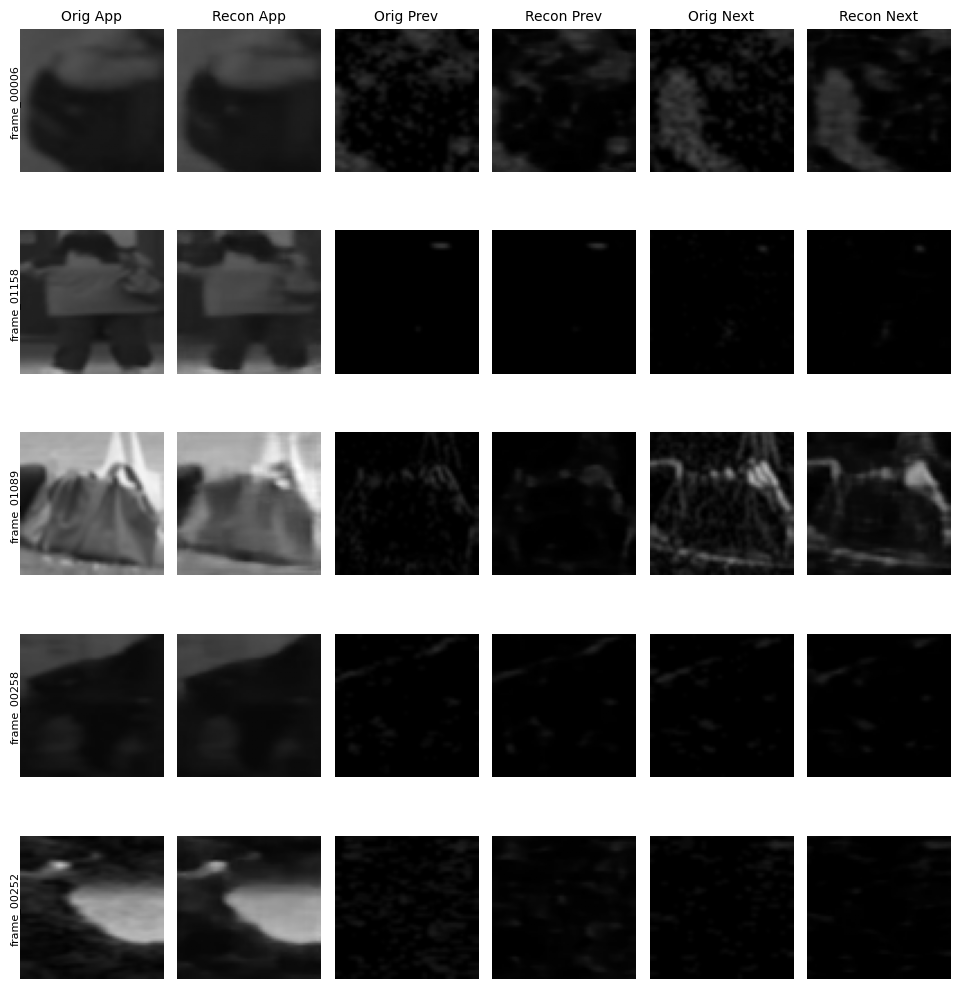

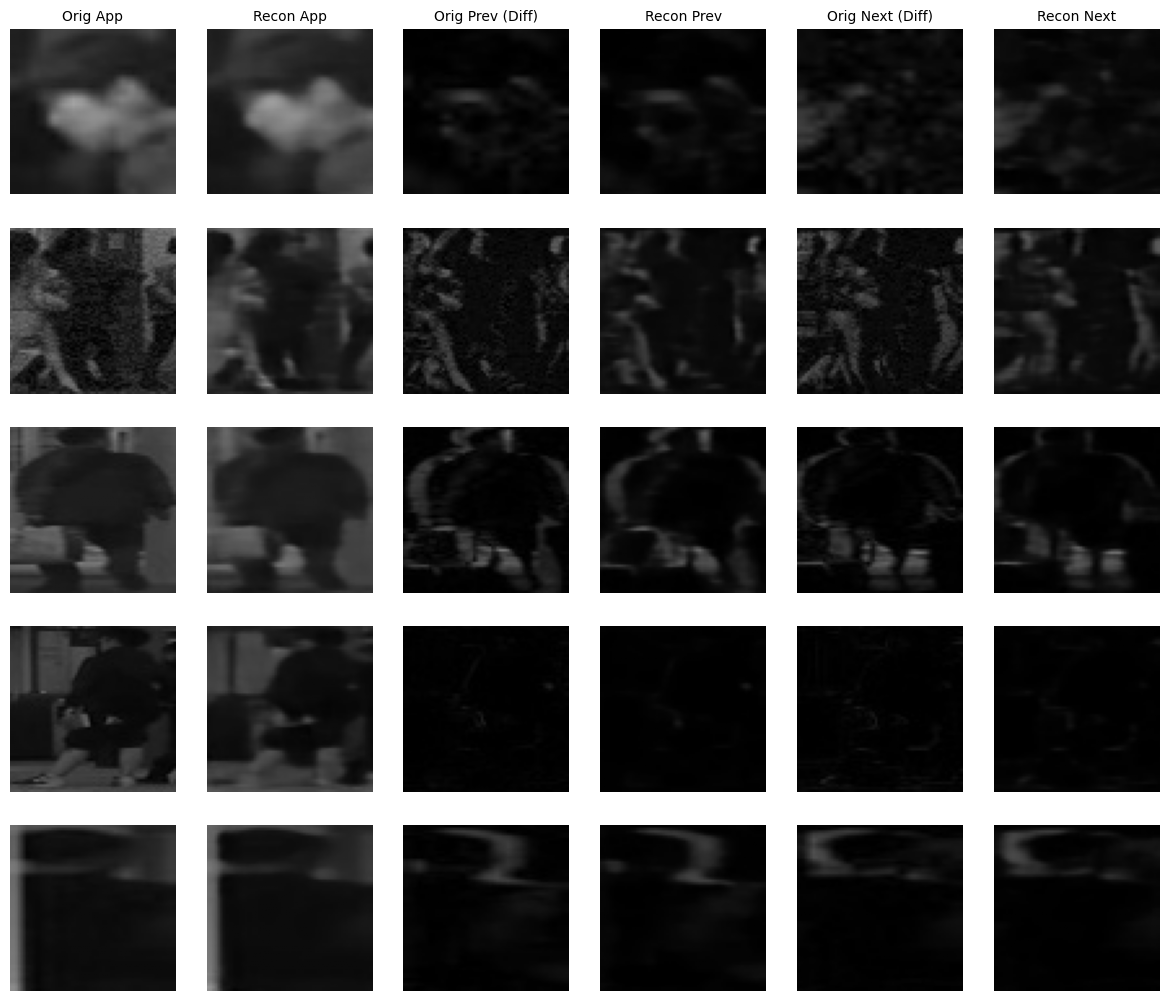

In [ ]:
import matplotlib.pyplot as plt

class VideoInferenceDataset(Dataset):
    def __init__(self, video_path, denoise=True):
        self.frame_folders = sorted(glob.glob(os.path.join(video_path, '*')))
        self.denoise = denoise
        self.transform = T.Compose([T.ToTensor()])
        
    def __len__(self):
        return len(self.frame_folders)

    def __getitem__(self, idx):
        frame_folder = self.frame_folders[idx]
        frame_id = os.path.basename(frame_folder)
        
        app_files = glob.glob(os.path.join(frame_folder, '*_app.jpg'))
        
        apps, prevs, nexts = [], [], []
        
        for app_p in app_files:
            prev_p = app_p.replace('_app.jpg', '_mot_prev.jpg')
            next_p = app_p.replace('_app.jpg', '_mot_next.jpg')

            img_app = cv2.imread(app_p, cv2.IMREAD_GRAYSCALE)
            img_prev = cv2.imread(prev_p, cv2.IMREAD_GRAYSCALE)
            img_next = cv2.imread(next_p, cv2.IMREAD_GRAYSCALE)
            
            if self.denoise:
                # Mild Gaussian Blur
                img_app = cv2.GaussianBlur(img_app, (3, 3), 0)
                
                # Thresholding + Blur
                _, img_prev = cv2.threshold(img_prev, 15, 255, cv2.THRESH_TOZERO)
                _, img_next = cv2.threshold(img_next, 15, 255, cv2.THRESH_TOZERO)
                
                # Smooth the remaining gradients
                img_prev = cv2.GaussianBlur(img_prev, (3, 3), 0)
                img_next = cv2.GaussianBlur(img_next, (3, 3), 0)

            apps.append(self.transform(img_app))
            prevs.append(self.transform(img_prev))
            nexts.append(self.transform(img_next))
            
        if not apps:
            return frame_id, None, None, None

        return frame_id, torch.stack(apps), torch.stack(prevs), torch.stack(nexts)

def visualize_reconstructions(dataset, models, device, n_samples=5):
    cae_app, cae_prev, cae_next = models
    cae_app.eval(); cae_prev.eval(); cae_next.eval()
    
    valid_indices = []
    
    # Scan randomly until we find enough frames with objects
    attempts = 0
    while len(valid_indices) < n_samples and attempts < 100:
        idx = np.random.randint(0, len(dataset))
        data = dataset[idx]
        if data[1] is not None:
            valid_indices.append(idx)
        attempts += 1

    fig, axes = plt.subplots(n_samples, 6, figsize=(12, 2.5 * n_samples))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    headers = ["Orig App", "Recon App", "Orig Prev", "Recon Prev", "Orig Next", "Recon Next"]
    
    for i, idx in enumerate(valid_indices):
        frame_id, apps, prevs, nexts = dataset[idx]
        
        # apps is (N, 1, 64, 64) -> (1, 1, 64, 64)
        app = apps[0].unsqueeze(0).to(device)
        prev = prevs[0].unsqueeze(0).to(device)
        next_ = nexts[0].unsqueeze(0).to(device)
        
        with torch.no_grad():
            rec_app = cae_app(app)[0]
            rec_prev = cae_prev(prev)[0]
            rec_next = cae_next(next_)[0]

        # Convert tensor to numpy image
        def to_img(t): return t.squeeze().cpu().numpy()

        imgs = [to_img(app), to_img(rec_app), 
                to_img(prev), to_img(rec_prev), 
                to_img(next_), to_img(rec_next)]
        
        # Handle axes array for 1 sample vs many
        ax_row = axes[i] if n_samples > 1 else axes

        for j, img in enumerate(imgs):
            ax = ax_row[j]
            ax.imshow(img, cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
            
            if i == 0: ax.set_title(headers[j], fontsize=10)
            if j == 0: ax.text(-5, 32, f"{frame_id}", rotation=90, va='center', fontsize=8)

    plt.show()

if __name__ == "__main__":    
    cae_app = ObjectCentricCAE().to(device)
    cae_prev = ObjectCentricCAE().to(device)
    cae_next = ObjectCentricCAE().to(device)
    cae_app.load_state_dict(torch.load(f"./checkpoints/cae_app_ep135.pth"), strict=False)
    cae_prev.load_state_dict(torch.load(f"./checkpoints/cae_prev_ep135.pth"), strict=False)
    cae_next.load_state_dict(torch.load(f"./checkpoints/cae_next_ep135.pth"), strict=False)

    test_dataset = VideoInferenceDataset("./content/testing_processed_data/patches/02", denoise=True)
    train_dataset = VideoInferenceDataset("./content/training_processed_data/patches/02", denoise=True)

    # 3. Visualize
    visualize_reconstructions(test_dataset, (cae_app, cae_prev, cae_next), device=device)
    visualize_reconstructions(train_dataset, (cae_app, cae_prev, cae_next), device=device)



## K-Means Clustering of Object Latent Spaces and Training Binary Classifiers on Them

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from PIL import Image
import joblib
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize

class TestPatchDataset(torch.utils.data.Dataset):
    def __init__(self, patches_root):
        self.app_paths = sorted(glob(os.path.join(patches_root, '*', '*', '*_app.jpg')))
        self.transform = T.Compose([T.Grayscale(1), T.ToTensor()])

    def __len__(self): return len(self.app_paths)

    def __getitem__(self, idx):
        app_path = self.app_paths[idx]
        prev_path = app_path.replace('_app.jpg', '_mot_prev.jpg')
        next_path = app_path.replace('_app.jpg', '_mot_next.jpg')

        return (self.transform(Image.open(app_path)),
                self.transform(Image.open(prev_path)),
                self.transform(Image.open(next_path)))

def extract_features(dataset, model_paths, device='mps'):
    print("Loading AutoEncoders for feature extraction")

    cae_app = ObjectCentricCAE().to(device)
    cae_prev = ObjectCentricCAE().to(device)
    cae_next = ObjectCentricCAE().to(device)

    cae_app.load_state_dict(torch.load(model_paths['app']))
    cae_prev.load_state_dict(torch.load(model_paths['prev']))
    cae_next.load_state_dict(torch.load(model_paths['next']))

    cae_app.eval()
    cae_prev.eval()
    cae_next.eval()

    loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=0)
    all_features = []

    print("Extracting features from training data...")
    with torch.no_grad():
        for batch_app, batch_prev, batch_next in tqdm(loader):
            batch_app = batch_app.to(device)
            batch_prev = batch_prev.to(device)
            batch_next = batch_next.to(device)

            # Get Latent Spaces (16x8x8)
            _, lat_app = cae_app(batch_app)
            _, lat_prev = cae_prev(batch_prev)
            _, lat_next = cae_next(batch_next)

            # Flatten: (B, 1024)
            flat_app = lat_app.view(lat_app.size(0), -1)
            flat_prev = lat_prev.view(lat_prev.size(0), -1)
            flat_next = lat_next.view(lat_next.size(0), -1)

            # Concatenate: (B, 3072)
            combined = torch.cat([flat_app, flat_prev, flat_next], dim=1)

            all_features.append(combined.cpu().numpy())

    return np.concatenate(all_features, axis=0)

def main():
    TRAINING_PATCHES_DIR = "./content/processed_data/patches"
    CHECKPOINT_DIR = "./checkpoints"

    MODEL_PATHS = {
        'app': f"{CHECKPOINT_DIR}/cae_app_ep135.pth",
        'prev': f"{CHECKPOINT_DIR}/cae_prev_ep135.pth",
        'next': f"{CHECKPOINT_DIR}/cae_next_ep135.pth"
    }

    dataset = TestPatchDataset(TRAINING_PATCHES_DIR)
    X_train = extract_features(dataset, MODEL_PATHS)
    print(f"Feature Matrix Shape: {X_train.shape}")
    print("Normalizing features (L2)")
    X_train = normalize(X_train, axis=1, norm='l2')

    # K-Means Clustering
    K = 10
    print(f"Clustering into {K} clusters")
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train)
    joblib.dump(kmeans, "kmeans_model.pkl")

    # Train One-Versus-Rest SVMs
    classifiers = []
    print("Training SVMs")

    for i in range(K):
        y_binary = (cluster_labels == i).astype(int)

        clf = LinearSVC(C=1.0, dual=False, class_weight='balanced', max_iter=10000)
        clf.fit(X_train, y_binary)
        classifiers.append(clf)

        print(f"Classifier {i+1} trained. (Positives: {sum(y_binary)})")

    joblib.dump(classifiers, "svm_classifiers.pkl")
    print("Training Complete. Models saved.")

if __name__ == "__main__":
    main()

## Visualizing Clusters Using PCA and t-SNE Projections

In [ ]:
import matplotlib.pyplot as plt
import joblib
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

def visualize_clusters():
    dataset = TestPatchDataset(PATCHES_DIR)
    
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    features = []
    
    print("Extracting features")
    with torch.no_grad():
        for apps, prevs, nexts in tqdm(loader):
            apps, prevs, nexts = apps.to(device), prevs.to(device), nexts.to(device)
            l_a = cae_app(apps).view(apps.size(0), -1)
            l_p = cae_prev(prevs).view(prevs.size(0), -1)
            l_n = cae_next(nexts).view(nexts.size(0), -1)
            features.append(torch.cat([l_a, l_p, l_n], dim=1).cpu().numpy())
    
    X = np.concatenate(features, axis=0)
    X = normalize(X, axis=1, norm='l2')

    # Load Clusters        
    kmeans = joblib.load("kmeans_model.pkl")
    labels = kmeans.predict(X)

    print("Running PCA")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    print("Running t-SNE")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Custom colormap for 10 distinct clusters
    cmap = plt.cm.get_cmap('tab10', 10)
    
    # Plot PCA
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap=cmap, alpha=0.6, s=10)
    ax1.set_title(f"PCA Projection of {X.shape[0]} Patches")
    ax1.set_xlabel("Principal Component 1")
    ax1.set_ylabel("Principal Component 2")
    
    # Plot t-SNE
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap=cmap, alpha=0.6, s=10)
    ax2.set_title("t-SNE Projection")
    ax2.set_xlabel("t-SNE Dimension 1")
    ax2.set_ylabel("t-SNE Dimension 2")
    
    cbar = plt.colorbar(scatter2, ax=[ax1, ax2], ticks=range(10))
    cbar.set_label('Cluster ID')
    
    plt.savefig("cluster_visualization.png")
    plt.show()

if __name__ == "__main__":
    visualize_clusters()

An output image that I had saved earlier:
![cluster visualizations](cluster_visualization.png)


## Model Inference

In [ ]:
import joblib
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.ndimage import median_filter
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T

class VideoInferenceDataset(Dataset):
    def __init__(self, video_path, denoise=True):
        self.frame_folders = sorted(glob(os.path.join(video_path, '*')))
        self.denoise = denoise
        self.transform = T.Compose([T.ToTensor()])
        
    def __len__(self): return len(self.frame_folders)

    def __getitem__(self, idx):
        frame_folder = self.frame_folders[idx]
        frame_id_str = os.path.basename(frame_folder) 
        
        app_files = glob.glob(os.path.join(frame_folder, '*_app.jpg'))
        apps, prevs, nexts = [], [], []
        
        for app_p in app_files:
            prev_p = app_p.replace('_app.jpg', '_mot_prev.jpg')
            next_p = app_p.replace('_app.jpg', '_mot_next.jpg')
            
            img_app = cv2.imread(app_p, cv2.IMREAD_GRAYSCALE)
            img_prev = cv2.imread(prev_p, cv2.IMREAD_GRAYSCALE)
            img_next = cv2.imread(next_p, cv2.IMREAD_GRAYSCALE)
            
            if self.denoise:
                img_app = cv2.GaussianBlur(img_app, (3, 3), 0)
                _, img_prev = cv2.threshold(img_prev, 15, 255, cv2.THRESH_TOZERO)
                _, img_next = cv2.threshold(img_next, 15, 255, cv2.THRESH_TOZERO)
                img_prev = cv2.GaussianBlur(img_prev, (3, 3), 0)
                img_next = cv2.GaussianBlur(img_next, (3, 3), 0)

            apps.append(self.transform(img_app))
            prevs.append(self.transform(img_prev))
            nexts.append(self.transform(img_next))
            
        if not apps:
            return frame_id_str, None, None, None

        return frame_id_str, torch.stack(apps), torch.stack(prevs), torch.stack(nexts)

def generate_submission():
    TEST_PATCHES_DIR = "./content/testing_processed_data/patches"
    CHECKPOINT_DIR = "./checkpoints"
    SVM_PATH = "svm_classifiers.pkl"
    OUTPUT_FILE = "submission.csv"
        
    cae_app = ObjectCentricCAE().to(device)
    cae_prev = ObjectCentricCAE().to(device)
    cae_next = ObjectCentricCAE().to(device)
    
    # cae_app.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/cae_app_ep135.pth", map_location=device), strict=False)
    # cae_prev.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/cae_prev_ep135.pth", map_location=device), strict=False)
    # cae_next.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/cae_next_ep135.pth", map_location=device), strict=False)
    cae_app.eval(); cae_prev.eval(); cae_next.eval()
    
    classifiers = joblib.load(SVM_PATH)
    
    submission_rows = []
    video_folders = sorted(glob(os.path.join(TEST_PATCHES_DIR, '*')))
    
    for video_path in video_folders:
        video_id = os.path.basename(video_path)
        print(f"Processing Video: {video_id}")
        
        dataset = VideoInferenceDataset(video_path, denoise=True)
        loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x[0])
        
        video_frames = []
        video_raw_scores = []
        
        with torch.no_grad():
            for frame_str, apps, prevs, nexts in tqdm(loader, leave=False):
                video_frames.append(frame_str)
                
                # Default Score for Empty Frame (Normal)
                if apps is None: 
                    video_raw_scores.append(0.0)
                    continue
                
                apps, prevs, nexts = apps.to(device), prevs.to(device), nexts.to(device)
                
                # Feature Extraction
                l_a = cae_app(apps).view(apps.size(0), -1)
                l_p = cae_prev(prevs).view(prevs.size(0), -1)
                l_n = cae_next(nexts).view(nexts.size(0), -1)
                feat = torch.cat([l_a, l_p, l_n], dim=1).cpu().numpy()
                
                feat = normalize(feat, axis=1, norm='l2')
                
                # Scoring
                svm_scores = np.array([clf.decision_function(feat) for clf in classifiers]).T
                
                # Anomaly = - Max(Normality)
                normality = np.max(svm_scores, axis=1)
                frame_anomaly = np.max(-normality)
                video_raw_scores.append(frame_anomaly)

        scores_arr = np.array(video_raw_scores)
        
        # Median Filtering
        smoothed = median_filter(scores_arr, size=19)
        
        # Filling scores for first 3 and last 3
        t = 3
        if len(smoothed) > t*2:
            smoothed[:t] = smoothed[t]     # Fill first t frames with value at t
            smoothed[-t:] = smoothed[-t-1] # Fill last t frames with value at len-t
            
        # Min-Max Normalization of scores
        if smoothed.max() - smoothed.min() > 0:
            final_scores = (smoothed - smoothed.min()) / (smoothed.max() - smoothed.min())
        else:
            final_scores = smoothed

        # 3. CONSTRUCT ROWS
        for frame_str, score in zip(video_frames, final_scores):
            # Submission Format: Id = "videoID_frameID"
            # Ensure frame_str is clean (remove .jpg extension if present, though VideoInferenceDataset handles folders)
            row_id = f"{video_id}_{frame_str}"
            submission_rows.append({'Id': row_id, 'Predicted': float(score)})

    df = pd.DataFrame(submission_rows)
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"Saved {len(df)} rows to {OUTPUT_FILE}")
    print(df.head())

if __name__ == "__main__":
    generate_submission()